## Phase - 4: Iterative Feature Reduction and Selection

### Approach

Two Steps:

    Step - 1: Get model stats with single feature 
    Step -2: Get model stats with Important features

### 1. Data Load and Pre-Processing required for modeling

#### Categorical Columns

'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login'

In [2]:
catg_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']

#### Continuous Columns

In [3]:
cont_cols = [ 'duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

In [4]:
target_variable = 'label'

#### Data Load

In [6]:
import pandas as pd
df = pd.read_csv("../datasets/kddcup99_csv.csv")

#### Dataset size

In [7]:
df.shape

(494020, 42)

494020 records with 41 features and 1 target variable ("label") for prediction

In [8]:
df.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal


As seen above, there are various type of malware attacks which can be grouped as "abnormal" to make this problem as binary classification problem

##### Group all malware attacks as "abnormal"

In [9]:
attack_types = list(df['label'].unique())
attack_types.remove('normal') # remove normal from attack types as we only want malware attacks to convert as abnormal

In [10]:
df['label'] = df['label'].replace(attack_types, 'abnormal')
df.shape

(494020, 42)

In [11]:
# both these columns have all values as 0, hence not useful for our experiments
df.drop(columns=['is_host_login'], inplace=True)
df.drop(columns=['num_outbound_cmds'], inplace=True)
catg_cols.remove('is_host_login')
cont_cols.remove('num_outbound_cmds')

In [12]:
df['label'].value_counts()

abnormal    396743
normal       97277
Name: label, dtype: int64

In [13]:
# Transform Target Binary label to 0 and 1
df['label'] = df['label'].map({'normal': 1, 'abnormal': 0})
df['label'].value_counts()

0    396743
1     97277
Name: label, dtype: int64

In [14]:
for cat_col in catg_cols:
    df[cat_col] = df[cat_col].astype(str)

### Iterative Feature Reduction

In [45]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def _convert_categorical_to_one_hot_encoding(dataset, column_name):
    dummy_values = pd.get_dummies(dataset[column_name])
    #print("dummy_values", dummy_values.shape[1])
    for category in dummy_values.columns:
        dummy_value_name = f"{column_name}-{category}"
        dataset[dummy_value_name] = dummy_values[category]
    dataset.drop(column_name, axis=1, inplace=True)
    return dataset

def build_best_model_from_previous_phase(XTRAIN, YTRAIN,XVALID,YVALID):
    best_model_selected = Sequential()
    best_model_selected.add(Dense(4, input_dim = len(XTRAIN[0, :]), activation='relu'))
    best_model_selected.add(Dense(1, activation='sigmoid'))
    best_model_selected.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=[ 'accuracy'])
    best_model_selected_history = best_model_selected.fit(XTRAIN, YTRAIN, validation_data = (XVALID, YVALID), 
                                            batch_size=256, epochs =2, verbose = 1)
    return best_model_selected, best_model_selected_history
    
def get_model_accuracy_with_single_input(input_df, input_feature: str):
    
    if input_df.shape[1] != 2:
        raise Exception("Expected single feature input dataset")
    
    if input_feature in catg_cols:
        print(f"Single input feature is categorical and is : {input_feature}")
        input_df = _convert_categorical_to_one_hot_encoding(input_df, input_feature)
    else:
        print(f"Single input feature is continous and is {input_feature}")
        df_CONTCOLS_MIN = df[[input_feature]].min(axis=0)
        df_CONTCOLS_MAX = df[[input_feature]].max(axis=0)
        input_df[[input_feature]] = (input_df[[input_feature]] - df_CONTCOLS_MIN) / (df_CONTCOLS_MAX - df_CONTCOLS_MIN)
    
    if input_df.isna().values.any() is False:
        raise Exception("Cannot proceed with modeling with null values")
    
    print(input_df.shape)
    input_df = input_df.sample(frac=1).reset_index(drop=True)
    X_numpy = input_df.drop(columns=['label']).to_numpy()
    Y_numpy = input_df['label'].to_numpy()
    print(X_numpy.shape, Y_numpy.shape)
    
    # Split into training and validation, 20% validation set and 80% training 
    index_20percent = int(0.2 * len(input_df.to_numpy()[:, 0]))
    print(index_20percent)
    XVALID = X_numpy[:index_20percent]
    YVALID = Y_numpy[:index_20percent]
    XTRAIN = X_numpy[index_20percent:]
    YTRAIN = Y_numpy[index_20percent:]
    best_model_selected, best_model_selected_history = build_best_model_from_previous_phase(XTRAIN, YTRAIN,XVALID,YVALID)
    return best_model_selected, best_model_selected_history
    


In [46]:
single_column_accuracy_stats = {}
all_cols = catg_cols + cont_cols
for single_feature in all_cols:
    
    model_object, model_selected_history = get_model_accuracy_with_single_input(df[[single_feature, 'label']], 
    # change epoch from 2 to 8                                                                                    single_feature)
    single_column_accuracy_stats[single_feature] = model_selected_history.history['val_accuracy'][-1]
    
    
    

Single input feature is categorical and is : protocol_type
(494020, 4)
(494020, 3) (494020,)
98804


<ipython-input-45-e6d62e69dca9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[dummy_value_name] = dummy_values[category]


Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.3614 - accuracy: 0.8116 - val_loss: 0.2852 - val_accuracy: 0.8400
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.2854 - accuracy: 0.8394 - val_loss: 0.2852 - val_accuracy: 0.8400
Single input feature is categorical and is : service
(494020, 67)
(494020, 66) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.2635 - accuracy: 0.9639 - val_loss: 0.1044 - val_accuracy: 0.9709
Epoch 2/2
1544/1544 [==============================] - 4s 3ms/step - loss: 0.1017 - accuracy: 0.9709 - val_loss: 0.1013 - val_accuracy: 0.9711
Single input feature is categorical and is : flag
(494020, 12)
(494020, 11) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.4913 - accuracy: 0.7929 - val_loss: 0.4548 - val_accuracy: 0.8037
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.4541 - accuracy: 0.80

C:\Users\PepsiHomeUser\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(494020, 2)
(494020, 1) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 2ms/step - loss: 0.5536 - accuracy: 0.8031 - val_loss: 0.4964 - val_accuracy: 0.8030
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.4961 - accuracy: 0.8031 - val_loss: 0.4962 - val_accuracy: 0.8030
Single input feature is continous and is src_bytes
(494020, 2)
(494020, 1) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.5527 - accuracy: 0.8031 - val_loss: 0.4979 - val_accuracy: 0.8019
Epoch 2/2
1544/1544 [==============================] - 4s 3ms/step - loss: 0.4957 - accuracy: 0.8034 - val_loss: 0.4978 - val_accuracy: 0.8019
Single input feature is continous and is dst_bytes
(494020, 2)
(494020, 1) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 2ms/step - loss: 0.5536 - accuracy: 0.8030 - val_loss: 0.4950 - val_accuracy: 0.8040
Epoch 2/2
1544/1544 [==============================] - 4s 3ms/s

1544/1544 [==============================] - 4s 2ms/step - loss: 0.4902 - accuracy: 0.8030 - val_loss: 0.4878 - val_accuracy: 0.8036
Single input feature is continous and is srv_diff_host_rate
(494020, 2)
(494020, 1) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.5264 - accuracy: 0.8259 - val_loss: 0.4448 - val_accuracy: 0.8283
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.4361 - accuracy: 0.8363 - val_loss: 0.4375 - val_accuracy: 0.8386
Single input feature is continous and is dst_host_count
(494020, 2)
(494020, 1) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.5536 - accuracy: 0.8025 - val_loss: 0.4931 - val_accuracy: 0.8054
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.4969 - accuracy: 0.8025 - val_loss: 0.4929 - val_accuracy: 0.8054
Single input feature is continous and is dst_host_srv_count
(494020, 2)
(494020, 1) (494020,)
98804

In [49]:
import pandas as pd
#pd.Dataframe(single_column_accuracy_stats)

In [63]:
single_column_accuracy_stats_df = pd.DataFrame.from_dict(single_column_accuracy_stats, orient='index', columns=['Accuracy'])

In [64]:
single_column_accuracy_stats_df['Accuracy'] = single_column_accuracy_stats_df.apply(lambda row: row['Accuracy'] * 100, axis=1)

<AxesSubplot:ylabel='Accuracy'>

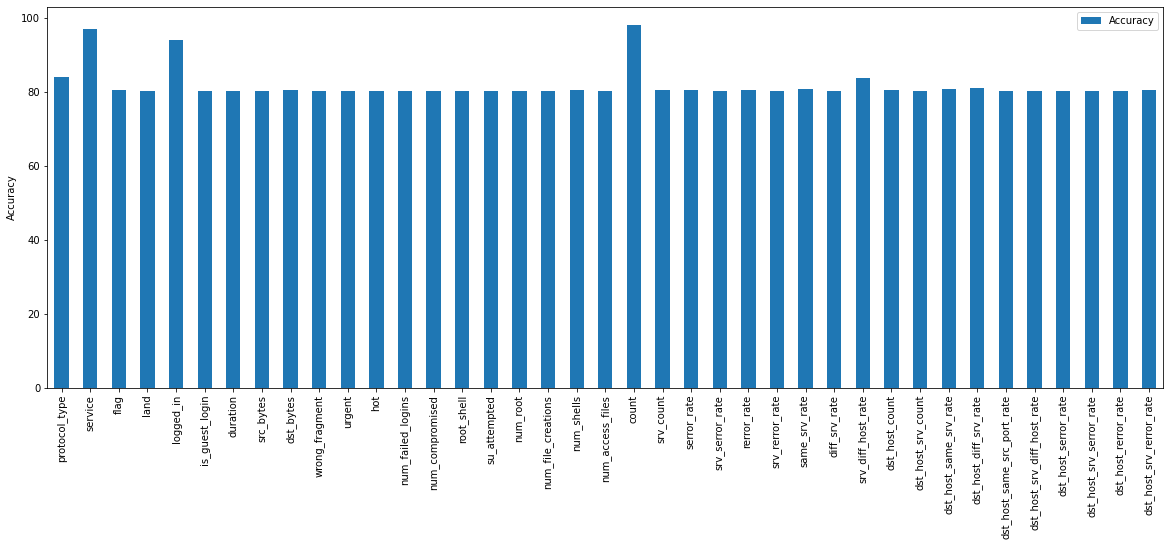

In [65]:
single_column_accuracy_stats_df.plot.bar(figsize=(20,7), ylabel='Accuracy')